# Space Invaders – Dueling DQN with Reward Shaping

**Course:** ITHS Deep Learning (HT23)

## 1. Översikt

Detta projekt tränar en **Dueling Double DQN**‑agent för att spela **Space Invaders**, med fokus på både **effektivitet** och **tolkbarhet**. De viktigaste komponenterna inkluderar:

- **Reward Shaping**: Logik baserad på alien-närhet och formationer för att uppmuntra strategiskt beteende.
- **Utforskningsförbättringar**: NoisyDense-lager och Prioritized Experience Replay (PER).
- **Snapshot och loggning**: Visuell och statistisk datainsamling under träning.
- **Policy- och Q-värdesvisualiseringar**: För att ge insikter i agentens beslutsprocess.

Agenten tränas i miljön `SpaceInvadersNoFrameskip-v4` med preprocessing från **AtariPreprocessing** och **FrameStack**. Systemet är byggt med hjälp av **TensorFlow**, **NumPy**, **Matplotlib** osv och stöder bland annat:

- **Övervakning via TensorBoard**
- **Diagnostik för belöningar**
- **Utvärdering och analys av policy**

Målet är inte bara att förbättra prestanda, utan också att **förstå agentens beslutstagande**.


## 2. Miljökonfiguration

Viktiga preprocessingssteg:

- **Bas-miljö**: `SpaceInvadersNoFrameskip-v4` för exakt frame-processing.
- **Atari-förbehandling**:
  - Omvandling till gråskala och nedskalning till **84x84** pixlar.
  - Pixelvärden i intervallet **0–255** (ingen normalisering).
- **Frame Stacking**: Fyra staplade bildrutor ger **tidsmässigt sammanhang**, vilket resulterar i formatet **(84, 84, 4)**.



## 3. Modellarkitektur

Agenten använder ett **Dueling Deep Q-Network (Dueling DQN)** från `utils/dueling_dqn.py` för att spela Space Invaders.

Den bearbetar fyra staplade bildrutor (från miljökonfigurationen) genom **konvolutionella neurala nätverk (CNNs)** för att identifiera viktiga visuella element som spelaren, fiender och skott.

De extraherade funktionerna skickas vidare till **NoisyDense-lager**, en speciell typ av fullt kopplade lager som injicerar parametriskt brus i sina vikter under träning. Detta inbyggda brus uppmuntrar agenten att utforska olika handlingar och strategier, som ett alternativ till traditionella metoder som epsilon-greedy.

En central del i denna modell är dess **Dueling-mekanism**. Istället för att direkt beräkna Q-värdet, delas beräkningen upp i två strömmar:

- Den ena strömmen uppskattar det **övergripande värdet** av det aktuella spel-läget *(V(s))* – alltså hur bra situationen är.
- Den andra strömmen uppskattar **fördelen** med att ta varje specifik handling *(A(s, a))* jämfört med andra handlingar i samma situation.

Dessa två strömmar kombineras sedan på ett smart sätt för att generera de slutliga **Q-värdena**, som styr agentens beslut.

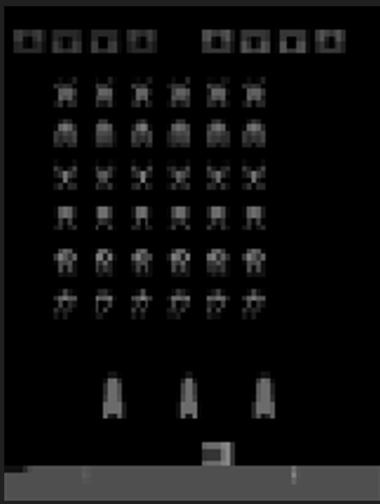

## 3. Träningsprocessen

### Träningsloop

1. Agenten observerar spelet och väljer en handling (Q-policy + utforskning).
2. Handling utförs → nytt tillstånd, belöning, episodstatus.
3. Erfarenheten sparas.
4. Modellen uppdateras regelbundet med batchar från minnet.

### Några centrala parametrar

- **Gamma** ≈ 0.99: Viktar framtida belöningar.
- **Learning rate**: Hur snabbt modellen justeras.
- **Batch size**: Antal exempel per uppdatering.

### Replay Buffer & PER

Erfarenheter sparas i en buffer och samplas slumpmässigt vid träning (minskar tidsberoende).  
**PER** prioriterar erfarenheter med hög TD-error (mer lärorika):
- `alpha`: styr prioritering.
- `beta`: korrigerar bias.

### Modelluppdatering

1. Beräkna Q-värden för batch.
2. Target-nätverk estimerar värde:
   `reward + gamma * Q_target(next_state, best_action)`.
3. **Loss (MSE)** beräknas.
4. Vikter justeras med Adam.

### Reward Shaping

Belöningssystemet förstärktes med logik för t.ex. bonusar i farliga zoner och straff för riskbeteenden.  
Just nu påverkas agentens prestanda eftersom den nyligen tvingats "lära om" grundrörelser (vänster, undvika skott) efter kodändringar.


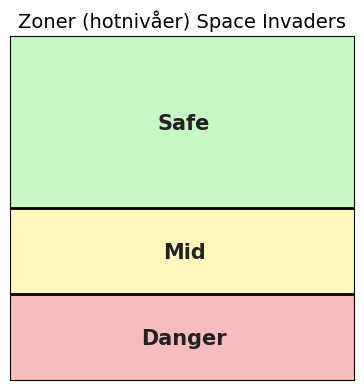

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensioner
height, width = 84, 84

# Skapa en tom bild
img = np.zeros((height, width, 3))

# Definiera zon-gränser
safe_end = 42
mid_end = 63

# Färger (r,g,b) normaliserade till [0,1]
safe_color = np.array([198, 247, 197]) / 255   # ljusgrön
mid_color = np.array([255, 247, 188]) / 255    # ljusgul
danger_color = np.array([247, 188, 188]) / 255 # ljusröd

# Måla respektive zon
img[:safe_end, :, :] = safe_color        # Safe
img[safe_end:mid_end, :, :] = mid_color  # Mid
img[mid_end:, :, :] = danger_color       # Danger

# Plot
plt.figure(figsize=(4,4))
plt.imshow(img, origin='upper')
plt.axhline(safe_end-0.5, color='black', linewidth=2)  # Gräns safe/mid
plt.axhline(mid_end-0.5, color='black', linewidth=2)   # Gräns mid/danger

# Textetiketter
plt.text(42, safe_end/2, "Safe", color='#222', fontsize=15, va='center', ha='center', weight='bold')
plt.text(42, (safe_end+mid_end)/2, "Mid", color='#222', fontsize=15, va='center', ha='center', weight='bold')
plt.text(42, (mid_end+height)/2, "Danger", color='#222', fontsize=15, va='center', ha='center', weight='bold')

plt.xticks([])
plt.yticks([])
plt.title('Zoner (hotnivåer) Space Invaders', fontsize=14)
plt.tight_layout()
plt.show()



### Reward Shaping: Vägleder agentens inlärning

Miljön i Space Invaders-spelet erbjuder i grunden **inbyggda belöningssignaler**, främst poäng för att eliminera utomjordingar. Dessa är dock ofta **glesa** och **fördröjda**. Med glesa belöningar menas att agenten kan utföra många handlingar innan den får någon form av återkoppling, vilket gör det svårt att koppla positiva eller negativa utfall till specifika tidigare beslut. Fördröjda belöningar förvärrar problemet ytterligare, då konsekvensen av en handling ofta visar sig långt senare i spelet.

För att hantera dessa utmaningar och möjliggöra en mer effektiv inlärning implementerades en strategi för **Reward Shaping** i detta projekt. Kärnan med reward shaping är att komplettera miljöns egna belöningar med ytterligare, mer frekventa och kontextuellt rika signaler. Dessa specialdesignade belöningar och bestraffningar syftar till att:

* Ge snabbare återkoppling för önskvärt eller oönskat kortsiktigt beteende.
* Dela upp komplexa långsiktiga mål (som att överleva en våg) i mer hanterbara delmål.
* Styra agentens utforskning mot strategiskt värdefulla delar av state-action space.
* Uppmuntra utvecklingen av mer nyanserade taktiker som överensstämmer med en expertspelare.

Utformningen av shaping-mekanismen grundades i en noggrann analys av Space Invaders centrala spelmekanik, bland annat hotbedömning baserat på utomjordingarnas närhet och formation, strategisk användning av defensiva skydd samt vikten av offensiv precision och effektivitet.


### Zoner och truppformationer

För att bättre kunna forma belöningsfunktionen och tolka agentens beteende delas spelskärmen in i **zoner** (baserat på vertikal position) och **trupper** (baserat på fiendernas formation):

#### Zoner (hotnivåer)


<table>
  <thead>
    <tr>
      <th>Zon</th>
      <th>Y-position</th>
      <th>Beskrivning</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color:#c8f7c5;color:#222;">
      <td><b>Safe</b></td>
      <td>y &lt; 42</td>
      <td>Låg risk – fienderna är långt från botten.</td>
    </tr>
    <tr style="background-color:#fff7bc;color:#222;">
      <td><b>Mid</b></td>
      <td>42 ≤ y &lt; 63</td>
      <td>Medelhög risk – fienderna närmar sig botten.</td>
    </tr>
    <tr style="background-color:#f7bcbc;color:#222;">
      <td><b>Danger</b></td>
      <td>y ≥ 63</td>
      <td>Kritisk risk – fiender nära botten, hög förlust-risk.</td>
    </tr>
  </tbody>
</table>


Zonerna baseras på den vertikala y-positionen (med en skärmhöjd på 84 px) och påverkar belöningens storlek beroende på hur farlig situationen är.

#### Trupper (fiendeformationer)

<table>
  <thead>
    <tr>
      <th>Trupp</th>
      <th>Beskrivning</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color:#c8f7c5;color:#222;">
      <td><b>BACK</b></td>
      <td>Översta två raderna – minst hot i början av spelet.</td>
    </tr>
    <tr style="background-color:#fff7bc;color:#222;">
      <td><b>MID</b></td>
      <td>Mitten två rader – medelhögt hot.</td>
    </tr>
    <tr style="background-color:#ffd6d6;color:#222;">
      <td><b>FRONT</b></td>
      <td>Nedersta två rader – mest hotfulla, skjuter och når botten först.</td>
    </tr>
    <tr style="background-color:#f3e4fc;color:#222;">
      <td><b>FLANKER</b></td>
      <td>Ytterkolumner (0 & 5) – kritiska för kontakt med väggen, kan fördröja eller orsaka förlust.</td>
    </tr>
  </tbody>
</table>



Dessa trupper kategoriserar vilken del av fiendeflottan agenten interagerar med. Det påverkar både **strategisk prioritering** och **reward shaping**.

Genom att tilldela högre belöningar för att eliminera fiender i DANGER-zonen och FRONT-trupper uppmuntras agenten att:

- Fokusera skjutandet på de nedersta raderna för att undvika game over.
- Undvika utsätta sig för fara genom att inte skjuta på BACK om det inte är nödvändigt.
- Eventuellt "campa" i de platser där flest hot dyker upp.

Denna reward shaping omvandlar **ren överlevnad** till **taktisk prioritering**, vilket liknar mänsklig strategi i Space Invaders.

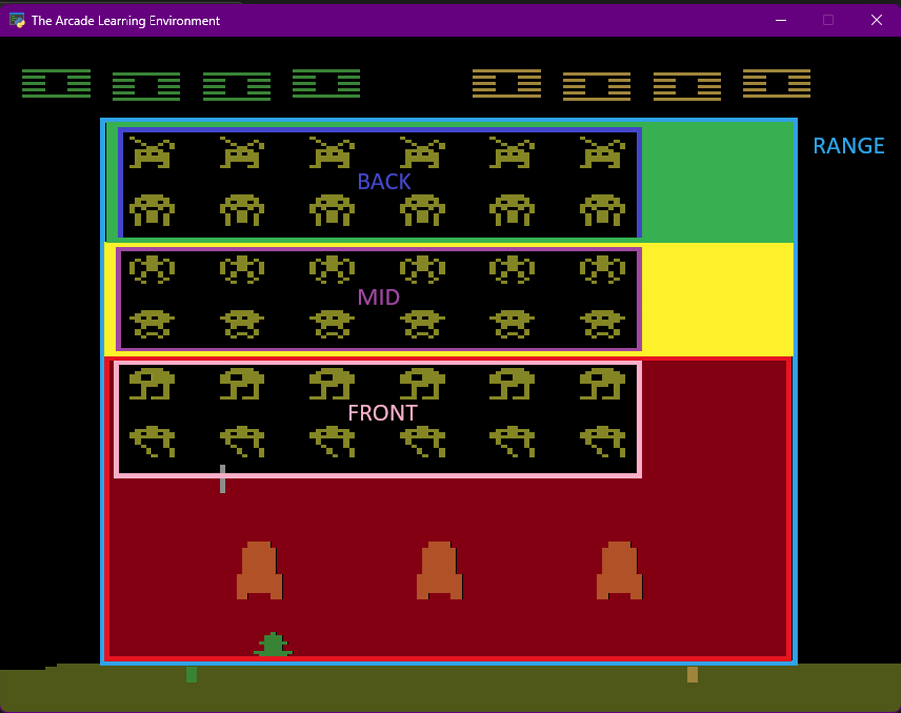


## 6. Träningsiterationer, Resultat och Utmaningar

Träningen av Space Invaders-agenten skedde iterativt, med många justeringar och observationer längs vägen. All träning genomfördes på en lokal dator utrustad med ett NVIDIA RTX 3060-grafikkort under Windows 11.

### Träningsförlopp och viktiga observationer

Träningen gick till på så sätt att funktioner successivt lades till och bort i ett ”learning by doing”-upplägg. Några centrala milstolpar och observationer var:

* **Initial fas (upp till ca 900 000 steg):** Tidig träning fokuserade på att få igång grundläggande Dueling DQN med NoisyDense-lager och Prioritized Experience Replay.
* **Införande av Reward Shaping (kring 900 000 steg):** En stor förändring var att reward shaping logik infördes. På grund av tidspress valdes att integrera detta i den pågående träningskörningen istället för att starta om från början, med förståelsen att agenten skulle behöva anpassa sig till de nya belöningssignalerna.
* **Utökad loggning (senare faser):** Funktioner som videoinspelning av gameplay var 500:e steg och snapshots infördes senare under processen. Dessa verktyg visade sig ovärderliga för att hitta buggar och observera agentens beteende mer direkt, snarare än att enbart förlita sig på TensorBoard-metriker. Till exempel identifierades och löstes ett problem med "svart skärm" i inspelningar tack vare denna visuella feedback.
* **Hantering av beteendebiaser: Det upptäcktes att agenten utvecklade en stark tendens att röra sig åt höger. För att motverka detta implementerades en tillfällig ”nudging”-mekanism: agenten fick specifika belöningar för vänsterrörelser tills sådana utgjorde minst 15% av agentens drag. Därefter inaktiverades denna extra belöning. Detta var ett försök att uppmuntra mer balanserad exploration då agenten hade under väldigt lång period inte försökt välja vänster som alternativ. Efter detta så har agenten varit bättre på rörelse men andra saker är nu i upplärning vilket gör att agenten blir straffad en del nu, kommer justera om värdena för att få ordning på detta.

**Lyckades hinna med *1 700 000* + steg.**

Agentens nuvarande prestation kan beskrivas som ”blandad”. Den har lärt sig att skjuta och röra sig, och hade stunder av till synes strategiskt spel (och, som nämnt, ”nästan vinst en gång”), men har inte bemästrat konsekvent komplexa taktiker som ihållande skyddsanvändning eller felfri undvikning av fiendekulor under den observerade träningstiden. Målet var att agenten skulle överleva länge och eliminera många aliens genom strategiskt spel, vilket den ibland visade tendenser till.



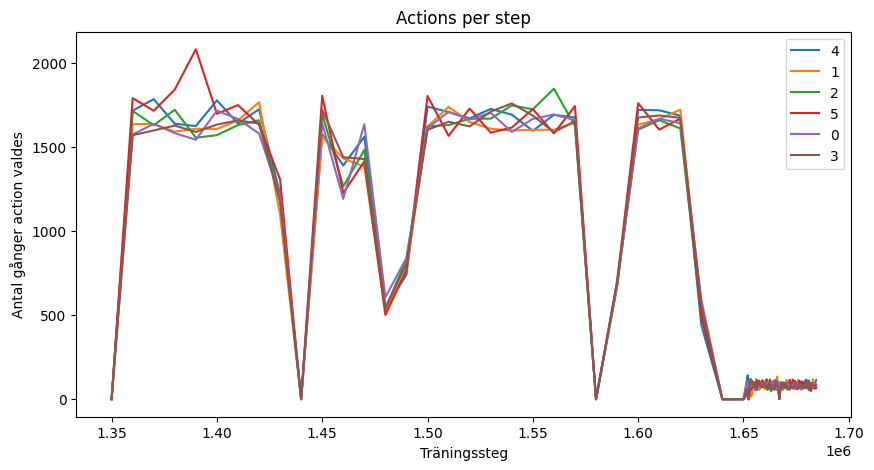

In [11]:
action_df.set_index("step")[action_cols].plot(figsize=(10,5))
plt.title("Actions per step")
plt.ylabel("Antal gånger action valdes")
plt.xlabel("Träningssteg")
plt.show()


### Några utmaningar och lösningar

Projektet stötte på flera utmaningar, främst kopplade till det iterativa och experimentella arbetssättet:

* **Inledande avsaknad av tydlig plan:** Att starta träningen utan en färdig plan för feature-implementering och hyperparameter-tuning innebar att många grundläggande element och övervakningsverktyg lades till successivt. Detta krävde ibland att agenten anpassades mitt under träningen, vilket inte alltid är optimalt.
* **Några av många tekniska problem:**
    * **”Svart skärm” i inspelningar:** Videologgning visade initialt bara svart skärm detta behövde felsökas och fixas. Här blev den nya videologgningen avgörande.
    * **NoisyDense-funktionalitet:** Insikten att NoisyDense-lagren kanske inte fungerade som tänkt ledde till ytterligare granskning och justeringar. Verkade inte användas korrekt, men funktionalitet lyckads fungera till slut.
    * **Beteendebiaser:** Agentens förkärlek för högerrörelser krävde en särskild åtgärd (nudging för vänsterrörelse) för att främja mer balanserad exploration.

* **Tuning av Reward Shaping:** Att införa shaping sent i träningen var riskfyllt. Finjustering av shaping-komponenterna och deras vikter för att få önskade beteenden utan att skapa oönskade bieffekter (som mycket negativ "Shaping Bias") var en stor utmaning som hanterades genom trial-and-error.
* **Begränsningar erfarenhet och tid:** Erfarenhetsbrist gjorde att tiden för saker och ting var svår att estimera. Varje större iteration eller felsökningsrunda för sent tillagda features (t.ex. avancerad shaping eller videologgning) kostade värdefull träningstid.

Många av dessa utmaningar löstes genom iterativ felsökning, noggrann observation av agentens beteende (hjälpt av video- och snapshotloggning), samt adaptiva kod- och belöningsjusteringar. Arbetet byggde mycket på ”game sense” och experimentell utveckling.


In [16]:
import sys, os, pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

root = pathlib.Path().resolve()
if str(root) not in sys.path:
    sys.path.append(str(root)) 

print(f"Notebook körs från: {root}")

import re, json
from pathlib import Path

eval_dir = Path("evaluation_outputs")

#  Ladda alla action-filer 
action_files = sorted(
    eval_dir.glob("action_dist_step*.json"),
    key=lambda p: int(re.search(r"step(\d+)", p.stem).group(1))
)

action_df = pd.DataFrame([
    {
        "step": int(re.search(r"step(\d+)", f.stem).group(1)),
        **json.load(f.open())
    }
    for f in action_files
]).fillna(0).astype({'step':'int'})

action_df.head()


Notebook körs från: C:\Users\vikto\Documents\Github\space_invaders_rl


,step,4,1,2,5,0,3
0,1350000,1.0,0.0,0.0,0.0,0.0,0.0
1,1360000,1716.0,1636.0,1714.0,1790.0,1574.0,1570.0
2,1370000,1784.0,1637.0,1629.0,1715.0,1637.0,1598.0
3,1380000,1638.0,1591.0,1721.0,1841.0,1582.0,1627.0
4,1390000,1624.0,1608.0,1555.0,2081.0,1543.0,1589.0


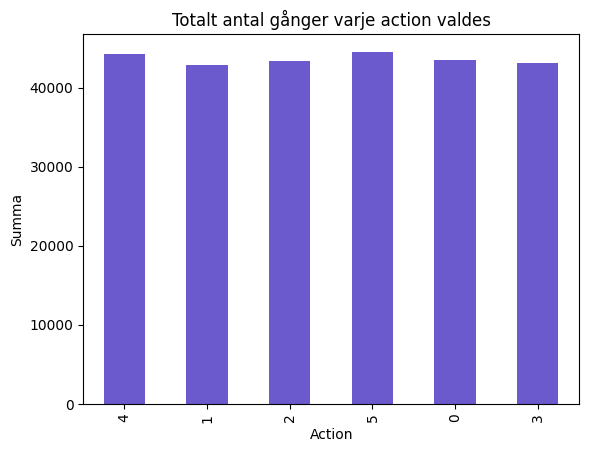

In [20]:
action_sums = action_df.drop(columns="step").sum()
action_sums.plot(kind='bar', color='slateblue')
plt.title("Totalt antal gånger varje action valdes")
plt.xlabel("Action")
plt.ylabel("Summa")
plt.show()


Lyckades få en totalt högervriden agent att bli mer balanserad till slut, det var nog den största bedriften.